# import

In [31]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
import pickle
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
import scipy.stats as stats
import scipy.io as sio

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# fig1: single cell trace across single trials
one noisy cell, one well-fit cell

## find session with good trace

In [2]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [3]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

In [4]:
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)

## load session trace

In [49]:
# df_tidy[(df_tidy.area == 'LM') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()
# df_tidy[(df_tidy.area == 'V1') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()

select_datesess = '230302_003    '.strip()
df_now = df_tidy[df_tidy.datesess == select_datesess]
area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + select_datesess
area_imouse_date_sess

'LM_i1373_230302_003'

In [50]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')

try:
    trace = sio.loadmat(dir_sess_trace)
except:
    area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
    dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
    trace = sio.loadmat(dir_sess_trace)
trace_by_trial = trace['trace_by_trial']
ncell = trace_by_trial.shape[0]
ntrial = trace_by_trial.shape[1]
nframe = trace_by_trial.shape[2]

print(f'ncell={ncell}, ntrial={ntrial}, nframe={nframe}')

ncell=139, ntrial=502, nframe=207


## find cells with large adp and R2

In [21]:
R2 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R2'}))

R1 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & ( 
           ((df_tidy.isi == 6000) & (df_tidy.resp_id == 'R2')) | 
           (df_tidy.resp_id == 'R1') )
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R1'}))

df_adp = pd.merge(R1, R2, on='cell_id')
df_adp['adp'] = (df_adp.R2 - df_adp.R1) / (df_adp.R1 + 1e-7)
df_adp = df_adp[(df_adp.R1 > 0) & (df_adp.R2 > 0.05)].sort_values('adp', ascending=True).reset_index(drop=True)
df_adp.head(10)

,cell_id,R1,R2,adp
0,230302_003_128,0.719837,0.295017,-0.590161
1,230302_003_81,0.304889,0.135118,-0.556830
2,230302_003_31,0.122934,0.054708,-0.554980
3,230302_003_70,0.143168,0.070537,-0.507312
4,230302_003_108,0.396317,0.208138,-0.474820
5,230302_003_127,0.179214,0.096002,-0.464317
6,230302_003_87,0.120051,0.075011,-0.375177
7,230302_003_58,0.129303,0.086960,-0.327471
8,230302_003_82,0.211765,0.145759,-0.311697
9,230302_003_89,0.212922,0.156721,-0.263952


In [22]:
## select example cells

cell_id = df_adp.head(10).cell_id.values
cell_id = [item.split('_')[-1] for item in cell_id]
cell_id = [int(item) for item in cell_id]
cell_id

[128, 81, 31, 70, 108, 127, 87, 58, 82, 89]

In [23]:
## select example trials (stim2 = 0, isi = 250, resp_id = R2)

trial_id = df_tidy[(df_tidy.datesess == select_datesess) 
            & (df_tidy.stim2_id == 0)
            & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
            ].trial_id.unique()
trial_id

array([  8,  41,  47, 104, 105, 140, 167, 188, 189, 214, 251, 269, 293,
       304, 328, 329, 340, 345, 372, 416, 426, 439, 450, 454, 482, 494],
      dtype=int64)

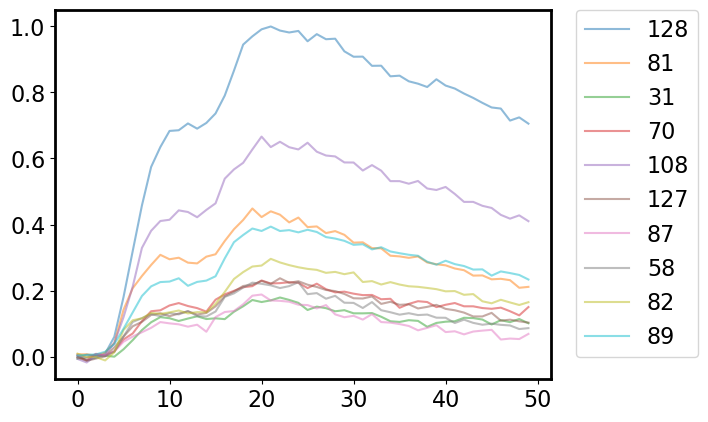

In [24]:
## choose cell by nice avg trace 

for icell in cell_id:
    trace_avg_cell = trace_by_trial[icell, trial_id, :50].mean(axis=0)
    plt.plot(trace_avg_cell, alpha=0.5);
plt.legend(cell_id, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

## single cell single trial trace

In [77]:
tail_frame_start = 190 # trace tail starts from this frame
frame_shift = nframe - tail_frame_start # length of trace tail
nframe_plot = 80 # number of frames to plot

trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]
trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

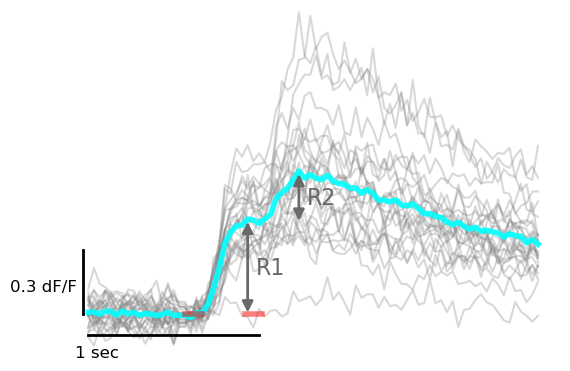

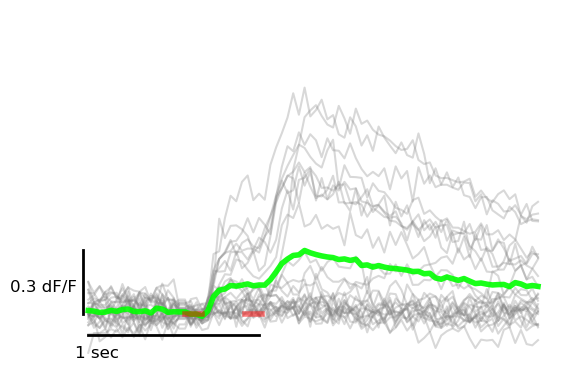

In [103]:
cell_id_example = [108, 82]
ylim_lower = trace_by_trial_reorder[cell_id_example, :, :]
ylim_lower = ylim_lower[:, trial_id, :].min() - 0.01
ylim_upper = trace_by_trial_reorder[cell_id_example, :, :]
ylim_upper = ylim_upper[:, trial_id, :].max() + 0.01
color_arr = ['cyan', 'lime']

for icell, single_cell_id in enumerate(cell_id_example):
    plt.figure(figsize=(6, 4))

    for itrial in trial_id:
        trace_trial = trace_by_trial_reorder[single_cell_id, itrial, :]
        plt.plot(trace_trial, alpha=0.3, color='gray');

    trace_agg_cell = trace_by_trial_reorder[single_cell_id, trial_id, :].mean(axis=0)
    plt.plot(trace_agg_cell, alpha=0.9, linewidth=4, color=color_arr[icell]);

    ## stim R1 and R2 arrow, only for the first cell
    if icell == 0:
        base1_id = 0 + frame_shift
        stim1_id = 11 + frame_shift
        base2_id = 13 + frame_shift
        # plt.axvline(base2_id, linestyle='--', color='dimgray', linewidth=2)
        stim2_id = 20 + frame_shift
        plt.annotate(text='', xy=(stim1_id, trace_agg_cell[base1_id]), xytext=(stim1_id, trace_agg_cell[stim1_id]), \
                    arrowprops=dict(arrowstyle='<|-|>', linewidth=2, color='dimgray'));
        plt.annotate(text='', xy=(stim2_id, trace_agg_cell[base2_id]), xytext=(stim2_id, trace_agg_cell[stim2_id]), \
                    arrowprops=dict(arrowstyle='<|-|>', linewidth=2, color='dimgray'));
    
        ## add text for arrow
        buffer_space = 4
        adjust_down_space = 0.06
        plt.text(stim1_id + buffer_space, (trace_agg_cell[stim1_id] + trace_agg_cell[base1_id]) / 2 - adjust_down_space, \
                'R1', ha='center', va='bottom', fontsize=16, color='dimgray')
        plt.text(stim2_id + buffer_space, (trace_agg_cell[stim2_id] + trace_agg_cell[base2_id]) / 2 - adjust_down_space, \
                'R2', ha='center', va='bottom', fontsize=16, color='dimgray')

    
    ## stim onset and offset
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100
    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=4, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=4, color='r', alpha=0.5);


    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, frame_rate * 1], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '1 sec', ha='center', va='top', fontsize=12);


    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);
    plt.ylim(ylim_lower, ylim_upper);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    plt.savefig(dir_fig + f'fig1_example_single_vis_cell_single_trial_trace_{single_cell_id}_{area_imouse_date_sess}.svg')

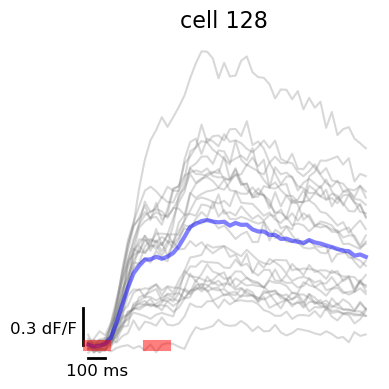

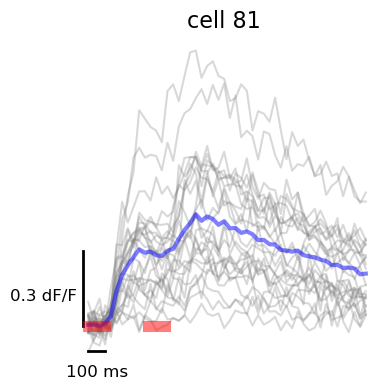

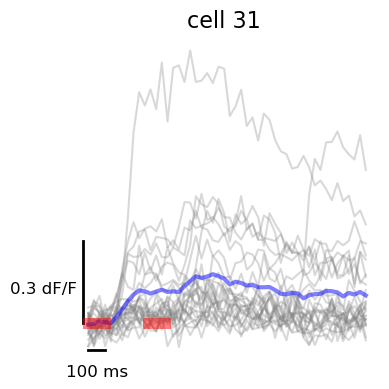

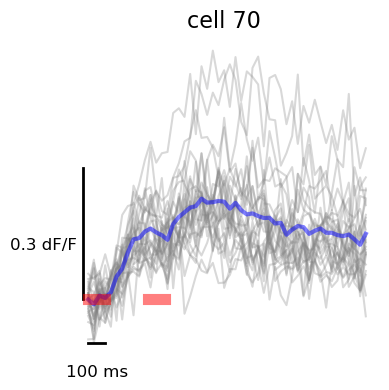

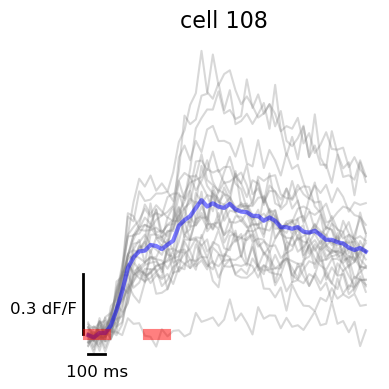

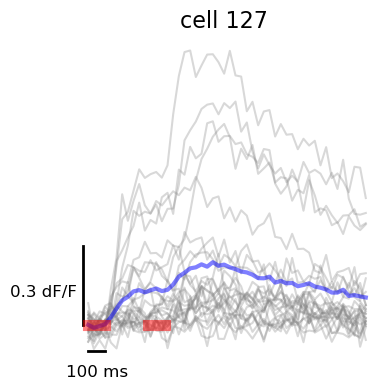

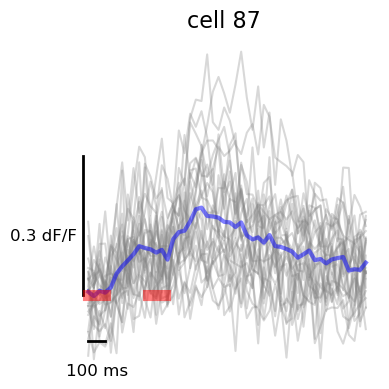

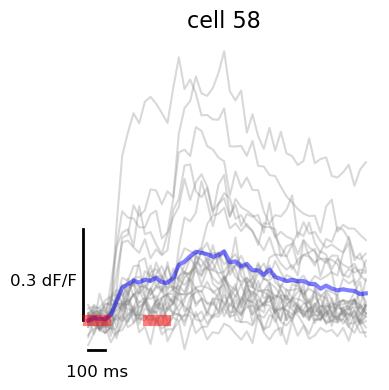

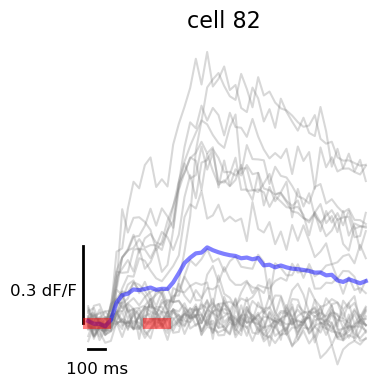

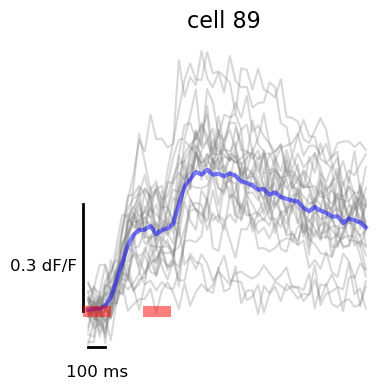

In [12]:
for single_cell_id in cell_id:
    plt.figure(figsize=(4, 4))

    # ylim_upper = 1.3
    ylim_lower = trace_by_trial[single_cell_id, trial_id, :50].min() - 0.01

    for itrial in trial_id:
        trace_trial = trace_by_trial[single_cell_id, itrial, :50]
        plt.plot(trace_trial, alpha=0.3, color='gray');
        # if trace_trial.max() <= ylim_upper:
        #     plt.plot(trace_trial, alpha=0.3, color='gray');
        # else:
        #     print(f'itrial={itrial}, max={round(trace_trial.max(), 2)}')

    trace_agg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
    # trace_agg_cell = np.median(trace_by_trial[single_cell_id, trial_id, :50], axis=0)
    plt.plot(trace_agg_cell, alpha=0.5, linewidth=3, color='blue');

    # plt.ylim(ylim_lower, ylim_upper);
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);

    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, 3], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '100 ms', ha='center', va='top', fontsize=12);

    frame_shift = 0
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100

    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5);

    plt.title(f'cell {single_cell_id}', fontsize=16);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    # plt.savefig(dir_fig + r'fig1_example_single_vis_cell_single_trial_trace.pdf')

# fig1: adaptation stability across trials

using new grat1  copied from grat1_mix50.ipynb  
inherited from [grat_SF6.ipynb from commit b8bb879](https://github.com/lanluo9/inter/blob/b8bb879ec03cdbd92b34296dc625f5f42966f6b2/scripts/ipynb/grat_SF6.ipynb)  
to get C:/Users/ll357/Documents/inter/results/R01/adp_stability_group_trials_grat1_plotly.svg

In [105]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [123]:
dir_csv = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1380_230207_cellpose'.replace('\\', '/')
filename = 'df_tidy.csv'
df_tidy = pd.read_csv(os.path.join(dir_csv, filename))
trial_ok = df_tidy.groupby('trial_id').filter_trial.first().astype(bool).values

mouse = 1380
date = 230207
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
dir_data += f'V1_i{mouse}_{date}_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1
base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2
resp_ad.shape, resp_tg.shape

ncell: 135, nstim: 1, ntrial: 1257, nframe: 257


((135, 1257), (135, 1257))

In [124]:
trace_by_trial_ori = trace_by_trial.copy()
stim_id_ori = stim_id.copy()
resp_ad_ori = resp_ad.copy()
resp_tg_ori = resp_tg.copy()

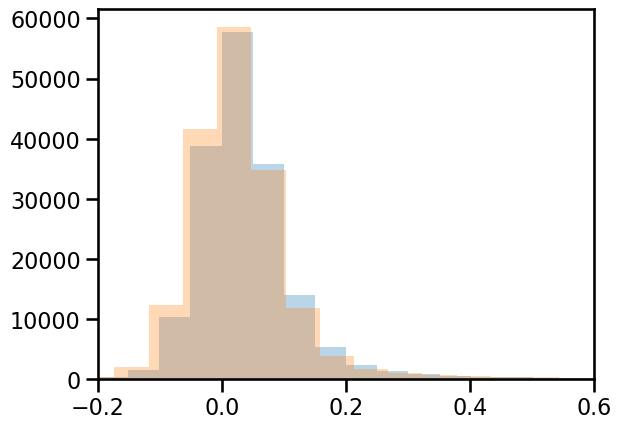

In [125]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

# trace_by_trial.shape, stim_id.shape, resp_ad.shape, resp_tg.shape, trial_ok.shape

## no trial filter

### pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [126]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((1257,), -0.31622181868903454, -0.1452518361800512)

In [127]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 10): # >= 10 groups of trials
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

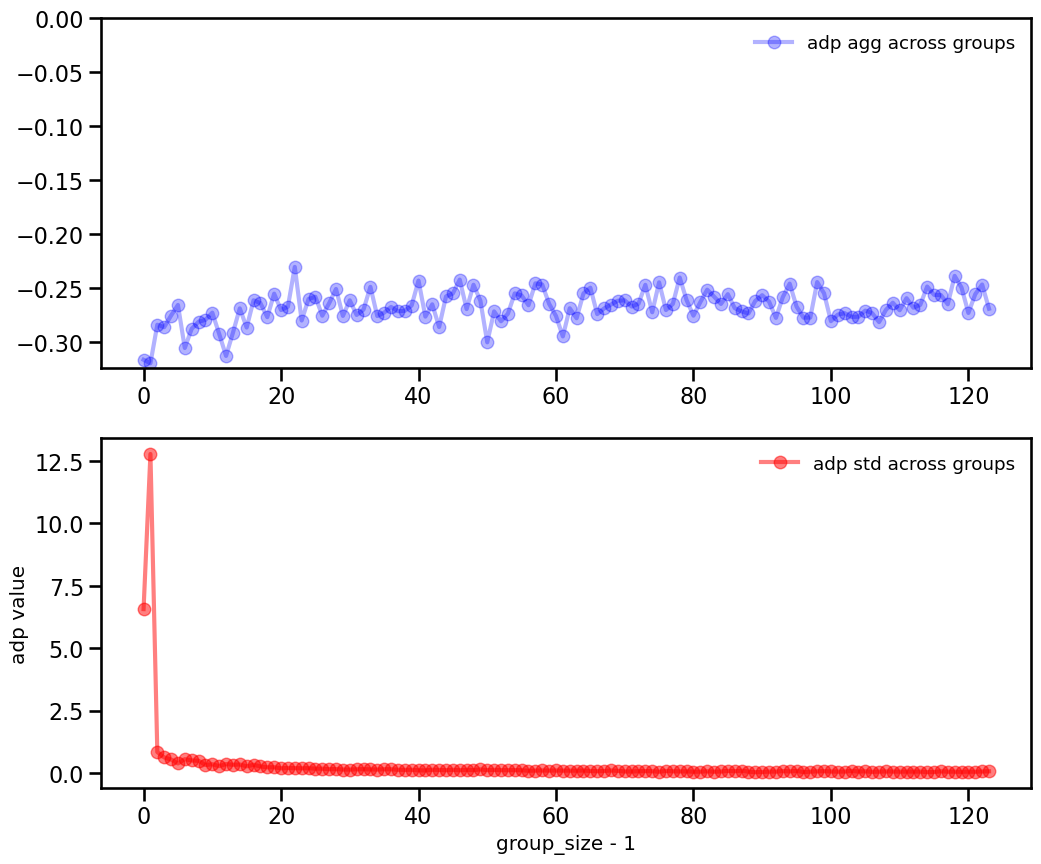

In [128]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
# plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.xscale('log')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

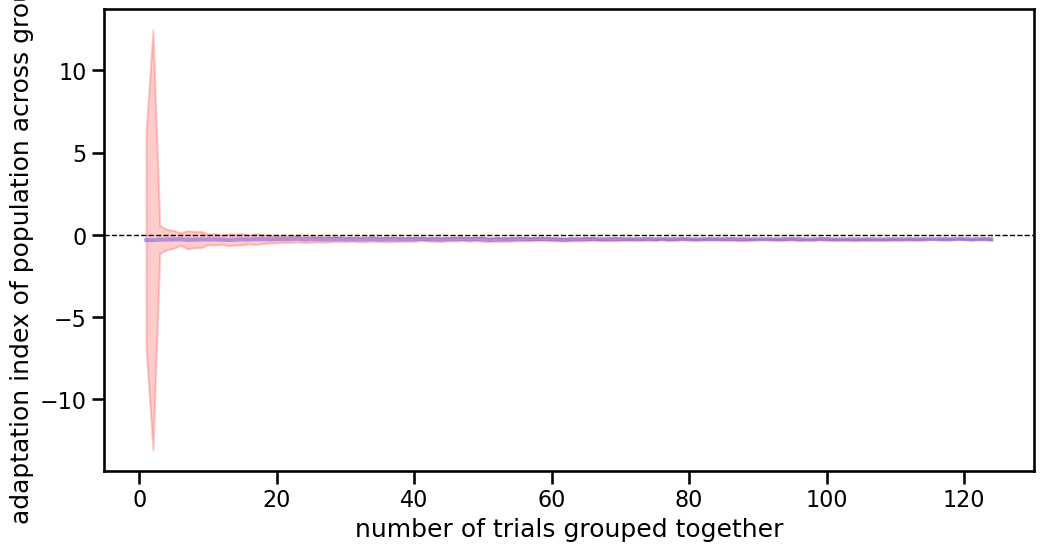

In [129]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

### single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [130]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

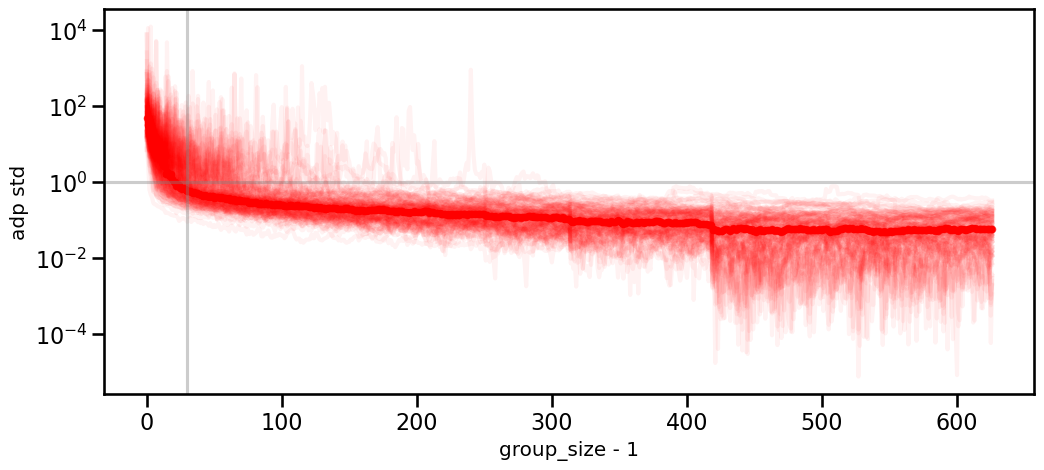

In [131]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, '.-', color='r', linewidth=1, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.axvline(30, alpha=0.4, color='gray')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

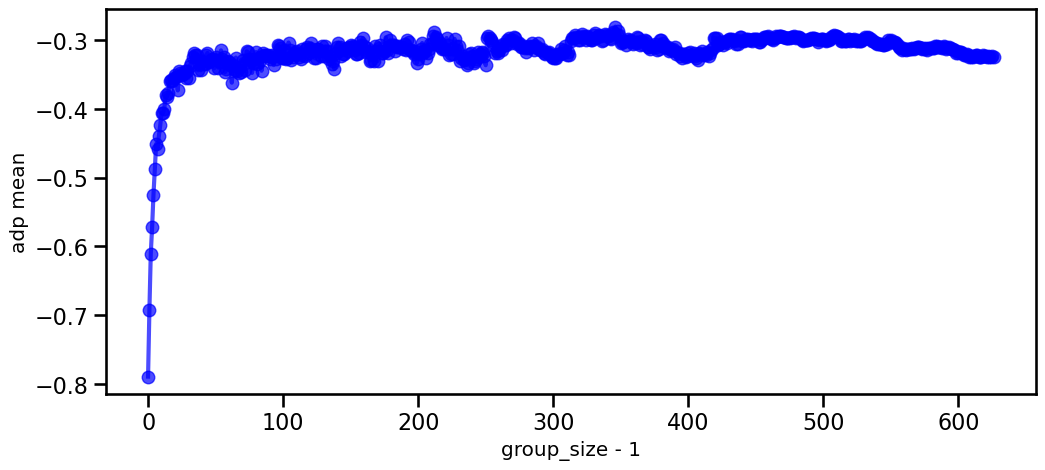

In [132]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

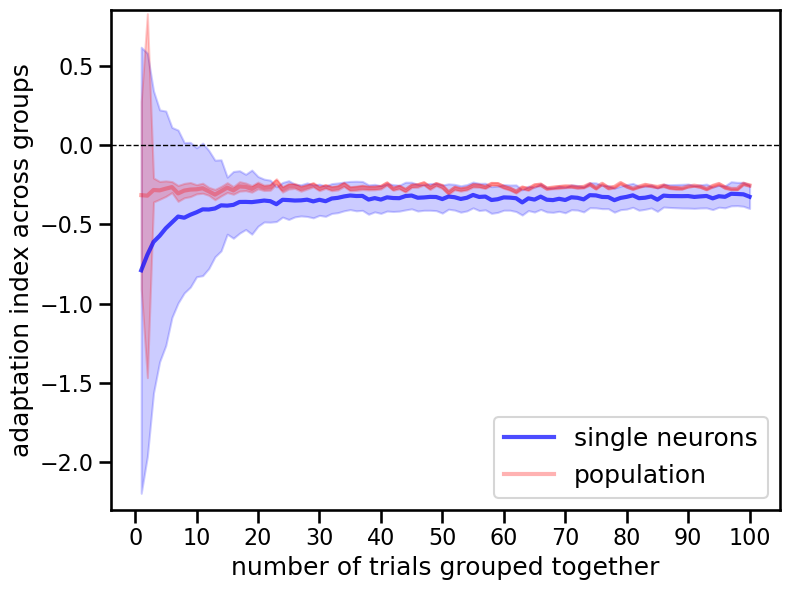

<Figure size 640x480 with 0 Axes>

In [133]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-2.3, 0.85)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials_grat_6SF.pdf'), format='pdf')

# fig2: adaptation violin plot across areas
see tuning_bias.ipynb -> cell level adp across area

# fig2: grand avg trace across areas

In [8]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')

def trace_grand_avg_area(df_tidy, select_area='V1'):
    df_fig2 = df_tidy.copy()
    df_fig2 = df_fig2[(df_fig2.area == select_area)
                    & (df_fig2.isi == 250) & (df_fig2.stim2_id == 0)
                    & (df_fig2.resp_id == 'R2')
                    & (df_fig2.filter_cell_vis == True)
                    ]

    trace_by_cell_concat = np.array([])
    for idatesess in tqdm(df_fig2.datesess.unique()):
        
        df_now = df_fig2[df_fig2.datesess == idatesess]
        try:
            area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + idatesess
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        except:
            area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        trace_by_trial = trace['trace_by_trial']

        cell_id = df_now.cell_id.unique()
        cell_id = [item.split('_')[-1] for item in cell_id]
        cell_id = [int(item) for item in cell_id]
        trial_id = df_now.trial_id.unique()

        trace_filtered = trace_by_trial[cell_id, :, :100]
        trace_filtered = trace_filtered[:, trial_id, :100]
        trace_by_cell = np.mean(trace_filtered, axis=1) # ncell x nframe, avg across trials of isi=250, ori=0
        
        if trace_by_cell_concat.size == 0:
            trace_by_cell_concat = trace_by_cell
        else: ## stack trace_by_cell onto trace_by_cell_concat
            trace_by_cell_concat = np.vstack([trace_by_cell_concat, trace_by_cell])

    print(trace_by_cell_concat.shape)
    trace_grand_avg = np.mean(trace_by_cell_concat, axis=0)
    trace_grand_sem = np.std(trace_by_cell_concat, axis=0) / np.sqrt(trace_by_cell_concat.shape[0])
    # trace_grand_avg = trace_grand_avg[:50]
    # trace_grand_sem = trace_grand_sem[:50]

    return trace_grand_avg, trace_grand_sem

In [32]:
# trace_avg_V1, trace_sem_V1 = trace_grand_avg_area(df_tidy, select_area='V1')
# trace_avg_LM, trace_sem_LM = trace_grand_avg_area(df_tidy, select_area='LM')
# trace_avg_LI, trace_sem_LI = trace_grand_avg_area(df_tidy, select_area='LI')

# trace_avg_list = [trace_avg_V1, trace_avg_LM, trace_avg_LI]
# trace_sem_list = [trace_sem_V1, trace_sem_LM, trace_sem_LI]
# area_list = ['V1', 'LM', 'LI']
# color_list = ['#85A7EB', '#F6CD51', '#D1A6DE']


# ## save to pickle
# trace_area = {'trace_avg_list': trace_avg_list,
#              'trace_sem_list': trace_sem_list,
#              'area_list': area_list,
#              'color_list': color_list}
# with open(dir_fig + 'trace_area.pkl', 'wb') as f:
#     pickle.dump(trace_area, f)


## load from pickle
with open(dir_fig + 'trace_area.pkl', 'rb') as f:
    trace_area = pickle.load(f)

trace_avg_list = trace_area['trace_avg_list']
trace_sem_list = trace_area['trace_sem_list']
area_list = trace_area['area_list']
color_list = trace_area['color_list']

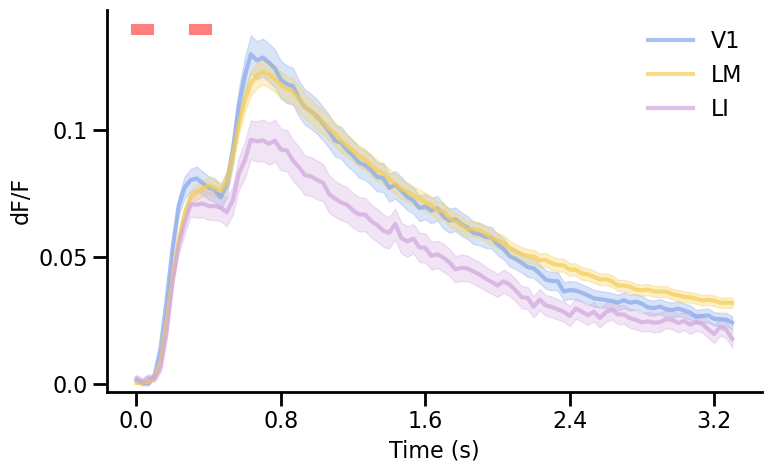

In [33]:
# plot trace avg and sem
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth'] = 2 # x and y axis thick
plt.figure(figsize=(8, 5))

for iarea, area in enumerate(area_list):
	trace_grand_avg = trace_avg_list[iarea]
	trace_grand_sem = trace_sem_list[iarea]
	plt.plot(trace_grand_avg, 
		  alpha=0.7, linewidth=3, 
		  color=color_list[iarea], 
		  label=area
		  )
	plt.fill_between(np.arange(trace_grand_avg.shape[0]),
			trace_grand_avg - trace_grand_sem, 
			trace_grand_avg + trace_grand_sem,
			alpha=0.3, 
			color=color_list[iarea]
			)


# # plot stim resp R1 R2 arrow
# base1_id = 0
# stim1_id = 10
# base2_id = 14
# stim2_id = 20
# plt.annotate(text='', xy=(stim1_id, trace_grand_avg[base1_id]), xytext=(stim1_id, trace_grand_avg[stim1_id]), \
#             arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));
# plt.annotate(text='', xy=(stim2_id, trace_grand_avg[base2_id]), xytext=(stim2_id, trace_grand_avg[stim2_id]), \
#             arrowprops=dict(arrowstyle='<->', linewidth=2, color='gray'));

# # add text for arrow
# buffer_space = 2.5
# adjust_down_space = 0.005
# plt.text(stim1_id + buffer_space, (trace_grand_avg[stim1_id] + trace_grand_avg[base1_id]) / 2 - adjust_down_space, \
#         'R1', ha='center', va='bottom', fontsize=16)
# plt.text(stim2_id + buffer_space, (trace_grand_avg[stim2_id] + trace_grand_avg[base2_id]) / 2 - adjust_down_space, \
#         'R2', ha='center', va='bottom', fontsize=16)


# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01)
stim2_time = np.arange(9.5, 11.5, 0.01)
y = np.ones(stim1_time.shape) * 0.14
plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5)

# # text annotation for stim-on time
# plt.text(1, 0.145, 'S1', ha='center', va='bottom', fontsize=16)
# plt.text(10.5, 0.145, 'S2', ha='center', va='bottom', fontsize=16)


# change xticks to time in sec
frame_rate = 30 # frame per second
step_size = 24
x = np.arange(0, trace_grand_avg.shape[0], step_size)
time_sec = np.arange(0, trace_grand_avg.shape[0], step_size) / frame_rate
labels = [str(t) for t in time_sec]
plt.xticks(x, labels);

# change yticks to be sparser
ymax = (np.array(trace_avg_list) + np.array(trace_sem_list)).max() + 0.01
step_size = 0.05
y = np.arange(0, ymax + step_size, step_size)
labels = [str(round(item, 2)) for item in y]
plt.yticks(y, labels);

# set axis
plt.ylim([-0.003, ymax])
plt.xlabel('Time (s)')
plt.ylabel('dF/F')
plt.grid(False)
plt.legend(frameon=False);
sns.despine();
plt.tick_params(axis='both', length=10, width=2) # x & ytick increase length and width
plt.tight_layout();

# plt.savefig(dir_fig + '/fig2_trace_grand_avg_across_area.pdf')
# plt.savefig(dir_fig + '/fig2_trace_grand_avg_across_area.svg')

# fig3: tuning bias across areas
see tuning_bias.ipynb -> tuning bias plot no fit & polar plot of tuning